# **AIML CA2 Assignment - Part A (Clustering)**
**Name**: JEROME LOKE  
**Student ID**: P2510707  
**Class**: DAAA/FT/1B/01  

---


Conclusion should include  
• How  I  perform  customer  segmentation  using  unsupervised  machine  learning algorithm in Python?  
• (!!) What are the characteristics of each customer cluster?  
• (!!) Which group of customer needs to pay more attention to?

What to do?
1. Use  clustering  techniques  to  understand  the  data  with  the  goal  of  answering the three questions above. Use scikit-learn library to build the model.  
2. In the Jupyter notebook, write your report detailing your implementation, your experiments and analysis (along with your Python code and comments), as well  as your answers to the questions at the end of your notebook.  
3. Include some tests of your clustering with different possible values of k.  
4. Determine the best possible value of k. And show how you can determine that this is the best value for k.  
5. Use more than just one clustering algorithm (so, not just k-means).  

6. Summarize  the  highlights  of  your  findings  in  slides.  Mention  the  machine learning process you went through, the data exploration, data cleaning, feature engineering, model building, and evaluation. Focus more on the result analysis.

Workflow:
1. EDA
2. Data Preprocessing  
3. Feature Engineering  
4. Model Clustering  
5. Model Evaluation  
6. Interpretation / Conclusion

---

### Import Libraries

In [2]:
# Data Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# clustering algorithms
from sklearn.cluster import KMeans

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

---

## **STAGE 1: EDA (Exploratory Data Analysis)**
* **Preview Dataset**: Display first 5 rows to understand its structure.
* **Shape**: Dataset has X rows and Y columns.
* **Info & Summary Statistics**: Analyse data types, non-missing counts, and key statistics (mean, standard deviation, etc.) for numerical columns.
* **Missing Values**: Identify missing values per column / overall.

### Load & Preview Dataset

In [3]:
df = pd.read_csv("./CA2-dataset/CA2-Customer-Data.csv")
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
print(f"rows: {df.shape[0]}, cols: {df.shape[1]}")

rows: 200, cols: 5


### Investigate Irregularities in Dataset

#### dtypes

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


* No necessary edits needed for column dtypes

#### Features (numerical then categorical)

In [5]:
df.describe()

,CustomerID,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


* Mean `Age` is ~39  

* Mean `Income (k$)` is ~60.6k$  

* #### **Key Observation:** `How Much They Spend` has no labelled unit, and interestingly ranges from 1.0 to 99.0. This suggests that this feature could represent a "spending score" of 1-99 instead of raw "money spent".

In [6]:
df.describe(include='O')

,Gender
count,200
unique,2
top,Female
freq,112


* `Gender` shows an imbalance (112 Females : 88 Males), might influence our clusters later on

#### Investigate `How Much They Spend`
Intuitively, this feature would represent the amount of money spent by each customer. However, the range of this feature is only between 1 - 99, which is strange as real-world data rarely caps at 99 so cleanly.  
We will investigate the feature's distributions to see whether it represents an engineered score between 1-99 or not.  

Key Assumptions:
* Real-world money data should be right-skewed
* Richer customers should have higher input values for this feature

##### 1. Distributions of `How Much They Spend`

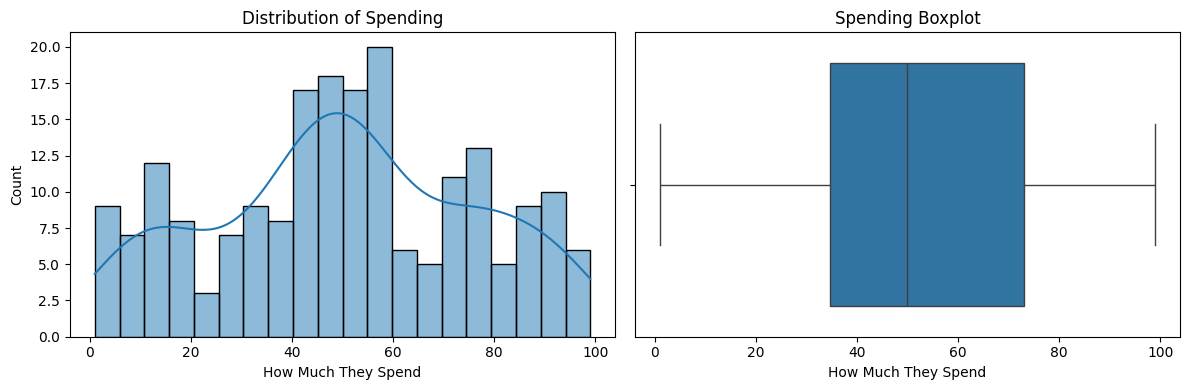

Median: 50.0
Q1: 34.75
Q3: 73.0


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# histogram
sns.histplot(df["How Much They Spend"], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Spending")
axes[0].set_xlabel("How Much They Spend")
axes[0].set_ylabel("Count")

# boxplot
sns.boxplot(x=df["How Much They Spend"], ax=axes[1])
axes[1].set_title("Spending Boxplot")
axes[1].set_xlabel("How Much They Spend")

plt.tight_layout()
plt.show()

print("Median:", df["How Much They Spend"].median())
print("Q1:", df["How Much They Spend"].quantile(0.25))
print("Q3:", df["How Much They Spend"].quantile(0.75))

* How Much They Spend displays a trimodal distribution instead of a right-skew, which supports the hypothesis that it the feature represents an engineered Spending Score of 1-99 instead of a raw spending amount.

##### 2. `Income (k$)` VS `How Much They Spend`
"Do richer people tend to spend more?"

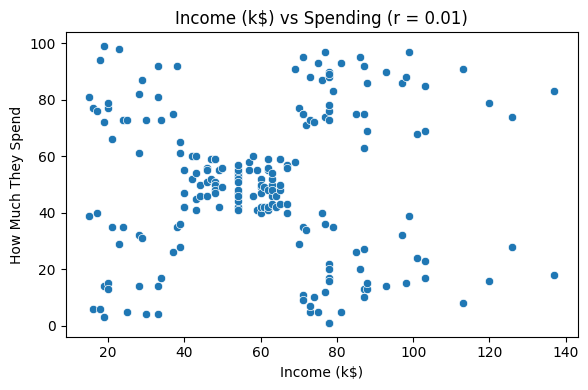

In [21]:
# calculate correlation coefficient
corr = df["Income (k$)"].corr(df["How Much They Spend"])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Income (k$)", y="How Much They Spend")
plt.title(f"Income (k$) vs Spending (r = {corr:.2f})")
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend")
plt.tight_layout()
plt.show()

* There is a ***weak*** positive relationship between `Income (k$)` and `How Much They Spend`, suggesting that richer people do not tend to spend more.  

* However, a more plausible conclusion is that customers were naturally separated into clusters as shown from the scatter plot. In fact, all high-earning customers (Income (k$) > 60) are separated into two groups: High spending and Low spending.

##### 3. Spending by Age Group
Split customers into five specific age ranges and compare their respective spending.  

"Do older customers tend to spend less?"

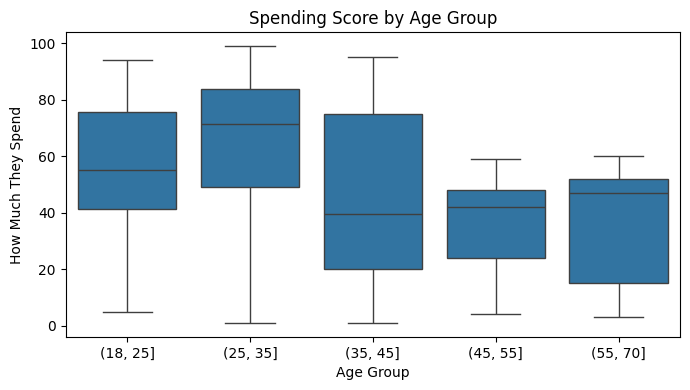

In [ ]:
df["Age Group"] = pd.cut(
  df["Age"],
  bins=[18, 25, 35, 45, 55, 70]
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x="Age Group", y="How Much They Spend")
plt.title("Spending by Age Group")
plt.tight_layout()
plt.show()


* Highest spending at the 26-35years age group, indicating young working adults show the highest spending potential.

* Widest variety of spending at the 36-45years age group, suggesting strong potential for growth via targeted campaigns.

* Older folks have a wider variety of spenders, with some spending way below the average (see the minimum). However, the median (Q2) spending of the 56-70years age group is actually higher than the 36-45 and 46-55 age groups, suggesting that older folks do not spend the least.

##### Conclusion: `How Much They Spend` = `Spending Score (1-99)`

In [23]:
df['Spending Score (1-99)'] = df['How Much They Spend']
df['Spending Score (1-99)'].head(10)

0    39
1    81
2     6
3    77
4    40
5    76
6     6
7    94
8     3
9    72
Name: Spending Score (1-99), dtype: int64

### Check Missing Data

In [7]:
df.isna().sum()

CustomerID             0
Gender                 0
Age                    0
Income (k$)            0
How Much They Spend    0
dtype: int64

* Dataset contains no missing data.  

* No irregularities found in column data (e.g. entries containing negative `Income (k$)` or huge `Age` values).  

* Dataset is ready to be preprocessed!

---

## **STAGE 2: Data Preprocessing**
* **Data Dropping**: Dropping Columns With Over 95% Missing Data (5% Non-Missing) or Irrelevant Data
* **StandardScaler, log-transform**: Scale data with skewed distributions to prevent them from dominating euclidean distance-based algorithms like KMeans